In [1]:
import argparse
import os
import sys
import numpy as np
import math
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from PIL import Image

# sys.path.insert(0,'gan-vae-pretrained-pytorch/cifar100_dcgan_grayscale/') # So we can import point_density_functions from parent directory
# from dcgan import Discriminator, Generator

%load_ext autoreload
%autoreload 2

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.10) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Optimizer and Plotting Functions

In [2]:
def sample_and_optimize(im,generator,z=100,op=torch.optim.Adam,
                        lr=1e-2,num_samples=100,num_early_epochs=1000,num_total_epochs=50000):
    '''For a single latent dimension, z, loop thru 
    i) trying num_samples samples for num_early_epochs epochs
    and ii) training the best for num_total_epochs epochs.
    Returns best image, best latent vector, loss_list for the chosen sample, big_loss_list for all the samples,
    big_x_list for all the latent vectors trained in the first phase, and the index of the chosen sample.
    '''

    # Accumulators
    big_loss_list = []
    big_x_list = []
    for i in range(num_samples):
        # Initialize x, the initial latent vector
        x_keep = Variable(Tensor(np.random.normal(0, 1, (1, z))),requires_grad=False)

        generator_list = [generator]
        x_keep_list = [x_keep.unsqueeze(2).unsqueeze(2)]
        im_list = [im]

        loss_dict,im_dict, x_dict = latent_dim_loop(generator_list,
                                                    x_keep_list,
                                                    im_list,
                                                    op,
                                                    lr,
                                                    schedule = False,
                                                    n_epochs=num_early_epochs)
        big_loss_list.append(loss_dict)
        big_x_list.append(x_dict)
    dict_key = "z="+str(x_keep.shape[1])
    min_losses = []
    for i,loss in enumerate(big_loss_list):
        min_losses.append(np.min(loss[dict_key]))

    # Find the best of the samples, optimizer further
    idx = np.argmin(loss100)
    x_keep = big_x_list[idx]['z=100']
    # x = x_keep.clone().requires_grad_()
    optimizer = torch.optim.Adam([x_keep],lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,40000], gamma=0.6)
    loss_list, im_g, x_out = grad_loop(im,x_keep,generator100,optimizer,
                                       scheduler=scheduler, n_epochs=num_total_epochs)
    return im_g, x_out, loss_list, big_x_list, big_loss_list, idx

# Functions for optimizing the gradient
def grad_loop(im,x,generator,optimizer,scheduler=None,n_epochs=10000,epsilon = 1):
    '''
    grad_loop finds the nearest image to im in the range of generator, 
    returns the loss curve and the generated image. 
    '''
    loss_list = []
    
    for epoch in range(n_epochs):

        optimizer.zero_grad()

#         im_g = generator(torch.clamp(x,-5,5))
        im_g = generator(x)

        loss = F.mse_loss(im_g,im,reduction = 'sum') / (im.size(2)*im.size(3))
        loss.backward(retain_graph=True)
        optimizer.step()
        if scheduler:
            scheduler.step()
        if epoch % 100 == 0:
            loss_list.append(loss.item())
            x_norm = torch.norm(x)
            print("Epoch {}\t Loss: {:2.4f}\t X Norm: {:2.4f}".format(epoch,loss,x_norm))
        if loss < epsilon:
            break
#     print("X max: ",x.max())
#     print("X min: ",x.min())
    return loss_list, im_g, x

def latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,schedule=False,n_epochs=10000):
    '''
    latent_dim_loop compares convergence rates for different latent dimensions.
    '''
    loss_dict = {}
    im_dict = {}
    x_dict = {}
    for i, generator in enumerate(generator_list):     
        x = x_keep_list[i].clone().requires_grad_()
        optimizer = op([x],lr=lr)
        if schedule:
            scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,40000], gamma=0.6) 
        else:
            scheduler=None
        dict_key = "z="+str(x.shape[1])
        loss_list,im_g,_ = grad_loop(im_list[i],x,generator,optimizer,scheduler,n_epochs=n_epochs,epsilon=1e-5)
        loss_dict[dict_key] = loss_list
        im_dict[dict_key] = im_g
        x_dict[dict_key] = x
        print("Opt: {}\tLR: {} Done".format(op,lr))
    plt.figure(figsize=[12,12])
    for k in loss_dict.keys():
        plt.plot(loss_dict[k],label=str(k))
    plt.legend(loc='upper right',fontsize=15)
    return loss_dict, im_dict, x_dict

def convergence_loop(op_list,lr_list,generator,x_keep,im,n_epochs=10000):
    '''
    convergence_loop compares learning rates and optimizers for on the grad_loop function.
    '''
    # Optimizer comparison loop
    loss_dict = {}
    for op in op_list:
        for lr in lr_list:
            x = x_keep.clone().requires_grad_()
            optimizer = op([x],lr=lr)
            dict_key = str(op)[-6:]+'_'+str(lr)
            loss_list,_,_ = grad_loop(im,x,generator,optimizer,n_epochs=n_epochs)
            loss_dict[dict_key] = loss_list
            print("Opt: {}\tLR: {} Done".format(op,lr))
    plt.figure(figsize=[12,12])
    for k in loss_dict.keys():
        plt.plot(loss_dict[k],label=str(k))
    plt.legend(loc='upper right',fontsize=15)
    return loss_dict

def plot_loss_curve(loss_dict,title,keys=None,start_idx = 0):
    
    '''Given a loss_dict where the optimizer name and LR are the key, plots the learning curves'''
    start_idx = round(start_idx,-2)
    if keys == None:
        keys = loss_dict.keys()
    plt.figure(figsize=[15,9])
    for k in keys:
        plt.plot(np.arange(start_idx,100*len(loss_dict[k]),100),loss_dict[k][int(start_idx/100):],label=str(k))
    plt.legend(loc='upper right',fontsize=15)
    plt.ylabel("MSE Loss per pixel",fontsize=12)
    plt.xlabel("Epoch",fontsize=12)
    plt.title(title,fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

def plot_loss_curve_list(loss_list,title,start_idx=0):    
    '''Given a loss_dict where the optimizer name and LR are the key, plots the learning curves'''
    start_idx = round(start_idx,-2)
    plt.figure(figsize=[15,9])
    for k in range(len(loss_list)):
        plt.plot(np.arange(start_idx,100*len(loss_list[k]),100),loss_list[k][int(start_idx/100):])
    plt.ylabel("MSE Loss per pixel",fontsize=12)
    plt.xlabel("Epoch",fontsize=12)
    plt.title(title,fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
# im is the target
def plot_img(im,grayscale=True):
    '''Plots image in gray or color. It doesn't consider vmin and vmax though.'''
    if im.min() < 0:
        im = im*0.5 + 0.5
    if grayscale:
        plt.imshow(im.detach().to('cpu')[0,0],cmap='gray')
    else:
        plt.imshow(im[0,:,:,:].detach().to('cpu').permute(1,2,0))

In [3]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is latent vector Z of shape (100 x 1 x 1), going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
              # state size. (ngf*16) x 4 x 4, where 4 = n+k-1= 1+4-1
              # to figure out the dimension of convtrans, just ask what dimension with the current setting gets you the current dimension
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
              # state size. (ngf*8) x 8 x 8, where 8 = (n-1)*s+k-2p = 3*2+4-2
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
              # state size. (ngf*4) x 16 x 16, where 16 = (n-1)*s+k-2p = 7*2+4-2
            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
              # state size. (ngf*2) x 32 x 32, where 32 = (n-1)*s+k-2p = 15*2+4-2
            nn.ConvTranspose2d(ngf*2, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
              # state size. (ngf*2) x 64 x 64, where 64 = (n-1)*s+k-2p = 31*2+4-2
            nn.ConvTranspose2d(ngf*2, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
              # state size. (ngf*2) x 128 x 128, where 128 = (n-1)*s+k-2p = 63*2+4-2
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 256 x 256, where 256 = (n-1)*s+k-2p = 127*2+4-2
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
              # state size. (nc) x 512 x 512, where 512 = (n-1)*s+k-2p = 255*2+4-2
            nn.Tanh()
        )
    def forward(self, input):
        return self.main(input)

In [4]:
## Load the generators
# Always true for microscope data
grayscale = True

# Load the generators UPDATE THIS FOR LOCATION OF MODELS
generator50 = torch.load("models/microscope/nz50_e200_G")
generator100 = torch.load("models/microscope/nz100_e400_G")
generator150 = torch.load("models/microscope/nz150_e400_G")

# GPU Stuff
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
num_gpu = 1 if torch.cuda.is_available() else 0

if torch.cuda.is_available():
    generator50 = generator50.cuda()
    generator100 = generator100.cuda()
    generator150 = generator150.cuda()

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


### Test 1: Find image in GAN latent space

In [ ]:
# Initialize z, the target latent vector 
z50 = Variable(torch.randn(1, 50))
z100 = Variable(torch.randn(1, 100))
z150 = Variable(torch.randn(1, 150))

# Generate im, the target image
im50 = generator50(z50.unsqueeze(2).unsqueeze(2).to('cuda'))
im100 = generator100(z100.unsqueeze(2).unsqueeze(2).to('cuda'))
im150 = generator150(z150.unsqueeze(2).unsqueeze(2).to('cuda'))

# Plot the images
plt.figure(figsize=[12,5])
plt.subplot(1,3,1)
plot_img(im50,grayscale)
plt.subplot(1,3,2)
plot_img(im100,grayscale)
plt.subplot(1,3,3)
plot_img(im150,grayscale)

In [ ]:
# Initialize x, the initial latent vector
x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)

In [ ]:
# For testing out optimizer parameters
# op_list = [torch.optim.SGD,torch.optim.Adam]
# lr_list = [1e-4,1e-2]
# loss_dict = convergence_loop(op_list,lr_list,generator,x_keep.unsqueeze(2).unsqueeze(2),im,n_epochs=10000)

In [ ]:
op = torch.optim.Adam
lr = 1e-2

generator_list = [generator50,generator100,generator150]
x_keep_list = [x_keep50.unsqueeze(2).unsqueeze(2),
               x_keep100.unsqueeze(2).unsqueeze(2),
               x_keep150.unsqueeze(2).unsqueeze(2)]
im_list = [im50,im100,im150]

loss_dict,im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=20000)

In [ ]:
plot_loss_curve(loss_dict,title='Learning curves for DCGAN on image in training set',start_idx=2000)

In [ ]:
# Compare loss across optimzers at a given epoch
for k in loss_dict.keys():
    print(k,": ",loss_dict[k][-1])

In [ ]:
plt.figure(figsize=[12,8])
plt.subplot(2,3,1)
plt.title("z = 50")
plt.ylabel("Original")
plot_img(im_list[0],grayscale)

plt.subplot(2,3,4)
k = sorted(im_dict.keys())[2]
plt.title(k)
plt.ylabel("Generated")
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

plt.subplot(2,3,2)
plt.title("z = 100")
plot_img(im_list[1],grayscale)

plt.subplot(2,3,5)
k = sorted(im_dict.keys())[0]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

plt.subplot(2,3,3)
plt.title("z = 200")
plot_img(im_list[2],grayscale)

plt.subplot(2,3,6)
k = sorted(im_dict.keys())[1]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

In [ ]:
# What's the norm of the difference between the vectors?
for z,x in zip([z50,z100,z150],[x_dict['z=50'][:,:,0,0].to('cpu'),
                                x_dict['z=100'][:,:,0,0].to('cpu'),
                                x_dict['z=150'][:,:,0,0].to('cpu')]):
    print("z={} norm: {:2.4f}\tOpt Norm: {:2.4f}\tDiff Norm {:2.4f}".format(z.size(1),torch.norm(z).item(),
                                                                            torch.norm(x).item(),torch.norm(z - x).item()))

### Aside: Is the GAN finding the same vector each time?
No, it isn't. Skip this section to run tests.

In [ ]:
# Multiple starting points, to see how many different optimal vectors are found
# Accumulators
big_loss_list = []
big_im_list = []
big_x_list = []
for i in range(10):
    # Initialize x, the initial latent vector
    x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
    x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
    x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)
    
    op = torch.optim.Adam
    lr = 1e-2

    generator_list = [generator50,generator100,generator150]
    x_keep_list = [x_keep50.unsqueeze(2).unsqueeze(2),
                   x_keep100.unsqueeze(2).unsqueeze(2),
                   x_keep150.unsqueeze(2).unsqueeze(2)]
    im_list = [im50,im100,im150]

    loss_dict,im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=20000)
    big_loss_list.append(loss_dict)
    big_im_list.append(im_dict)
    big_x_list.append(x_dict)

In [ ]:
# Load 10 examples for each latent dimension
import pickle

big_x_list = pickle.load( open( "microscope_output/big_x_dict.pkl", "rb" ) )
big_im_list = pickle.load( open( "microscope_output/big_im_list.pkl", "rb" ) )
big_loss_list = pickle.load( open( "microscope_output/big_loss_list.pkl", "rb" ) )

In [ ]:
x50_list = []
x100_list = []
x150_list = []
for i,x_dict in enumerate(big_x_dict):
    x50_list.append(x_dict['z=50'])
    x100_list.append(x_dict['z=100'])
    x150_list.append(x_dict['z=150'])

In [ ]:
# The optimized images
plt.figure(figsize=[15,15])
plt.subplot(3,4,1)
plot_img(im50,grayscale)
for i in range(10):
    plt.subplot(3,4,i+2)
    plot_img(generator50(x50_list[i]),grayscale)

In [ ]:
# How similar are the vectors?
sim_mat = np.zeros([len(x50_list),len(x50_list)])
for i in range(len(x50_list)):
    for j in range(len(x50_list)):
        sim_mat[i,j] = torch.norm(x50_list[i]-x50_list[j])
        
plt.figure(figsize=[10,10])
plt.imshow(sim_mat)
plt.xticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.yticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.colorbar()

In [ ]:
# How similar are the vectors?
sim_mat = np.zeros([len(x150_list),len(x150_list)])
for i in range(len(x150_list)):
    for j in range(len(x150_list)):
        sim_mat[i,j] = torch.norm(x150_list[i]-x150_list[j])
        
plt.figure(figsize=[10,10])
plt.imshow(sim_mat)
plt.xticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.yticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.colorbar()

In [ ]:
# How similar are the vectors?
sim_mat = np.zeros([len(x100_list),len(x100_list)])
for i in range(len(x100_list)):
    for j in range(len(x100_list)):
        sim_mat[i,j] = torch.norm(x100_list[i]-x100_list[j])
        
plt.figure(figsize=[10,10])
plt.imshow(sim_mat)
plt.xticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.yticks(np.arange(len(x50_list)),np.arange(len(x50_list)))
plt.colorbar()

### Test 2: Find closest image to random cropped sample

#### Load microscope image

In [5]:
class ParticleDatset(torch.utils.data.Dataset):
    def __init__(self, root_dir,im_size=512):
        super().__init__()
        self.root_dir = root_dir
        self.im_list = os.listdir(root_dir)
        self.n = len(self.im_list)
        self.im_size = im_size

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        im = Image.open(root_dir+self.im_list[index])
        im = transforms.RandomCrop(512)(im)
        out = transforms.ToTensor()(im)
        out = transforms.Normalize(0.5,0.5)(out)
        return out

In [6]:
root_dir = 'data/microscope/10/10/'  # UPDATE THIS FOR LOCATION OF MICROSCOPE DATA
dataset = ParticleDatset(root_dir,512)
dataloader =  torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True)

In [7]:
# Always true for microscope data
grayscale = True

# Load the generators
generator50 = torch.load("models/microscope/nz50_e200_G")
generator100 = torch.load("models/microscope/nz100_e400_G")
generator150 = torch.load("models/microscope/nz150_e400_G")

# GPU Stuff
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
num_gpu = 1 if torch.cuda.is_available() else 0

if torch.cuda.is_available():
    generator50 = generator50.cuda()
    generator100 = generator100.cuda()
    generator150 = generator150.cuda()

/home/michael/python-virtual-environments/data/lib/python3.6/site-packages/torch/serialization.py:623: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


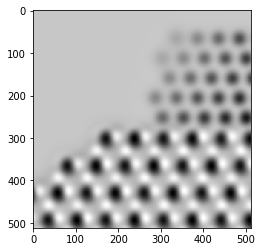

In [8]:
# Initialize x, the initial latent vector
x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)

# Generate im, the target image
im = next(iter(dataloader))
im = im.to('cuda')
plot_img(im,grayscale)

### Match up the Mean and SD
Skip this section, go to "Back to Test" below

In [ ]:
dataloader_mean =  torch.utils.data.DataLoader(dataset,batch_size=100, shuffle=True)
im = next(iter(dataloader_mean))
print("Mean: {:2.4f}\tSD: {:2.4f}".format(im.mean().item(),im.std().item()))

In [ ]:
from collections import defaultdict
mean_dict = defaultdict(list)
sd_dict = defaultdict(list)

def doit(mean_dict,sd_dict):
    x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
    x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
    x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)

    im50 = generator50(x_keep50.unsqueeze(2).unsqueeze(2).to('cuda'))
    im100 = generator100(x_keep100.unsqueeze(2).unsqueeze(2).to('cuda'))
    im150 = generator150(x_keep150.unsqueeze(2).unsqueeze(2).to('cuda'))
    mean_dict['50'].append(im50.mean().item())
    mean_dict['100'].append(im100.mean().item())
    mean_dict['150'].append(im150.mean().item())
    sd_dict['50'].append(im50.std().item())
    sd_dict['100'].append(im100.std().item())
    sd_dict['150'].append(im150.std().item())
#     print("Mean: {:2.4f}\tSD: {:2.4f}\tMin: {:2.4f}\tMax: {:2.4f}".format(im50.mean().item(),im50.std().item(),im50.min().item(),im50.max().item()))
#     print("Mean: {:2.4f}\tSD: {:2.4f}\tMin: {:2.4f}\tMax: {:2.4f}".format(im100.mean().item(),im100.std().item(),im100.min().item(),im100.max().item()))
#     print("Mean: {:2.4f}\tSD: {:2.4f}\tMin: {:2.4f}\tMax: {:2.4f}".format(im150.mean().item(),im150.std().item(),im150.min().item(),im150.max().item()))
    return mean_dict, sd_dict

for i in range(1000):
    mean_dict,sd_dict = doit(mean_dict,sd_dict)

In [ ]:
for key in mean_dict.keys():
    print("{}\tMean: {:2.4f}\tSD: {:2.4f}".format(key,np.mean(mean_dict[key]),np.mean(sd_dict[key])))

In [ ]:
# Means and SDs from experiment
im = dict("mean": 0.443,"SD":0.0628 )
im50 = dict("mean": -0.2096,"SD": 0.1531)
im100 = dict("mean": -0.1699,"SD": 0.113)
im150 = dict("mean": -0.1242,"SD": 0.1144)

### Back to the test

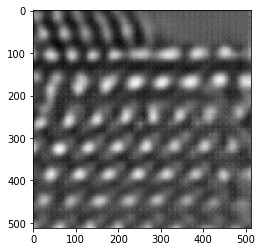

In [9]:
# Generate im_first, the initial guess image
with torch.no_grad():
    im_first = generator50(x_keep50.unsqueeze(2).unsqueeze(2).to('cuda'))
    plot_img(im_first,grayscale)

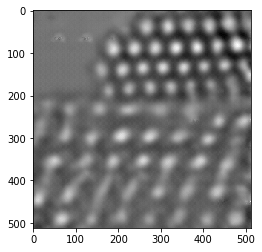

In [10]:
# Generate im_first, the initial guess image
with torch.no_grad():
    im_first = generator100(x_keep100.unsqueeze(2).unsqueeze(2).to('cuda'))
    plot_img(im_first,grayscale)

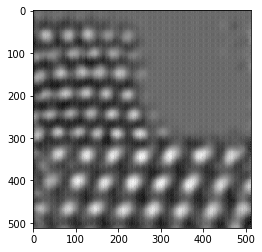

In [11]:
# Generate im_first, the initial guess image
with torch.no_grad():
    im_first = generator150(x_keep150.unsqueeze(2).unsqueeze(2).to('cuda'))
    plot_img(im_first,grayscale)

Epoch 0	 Loss: 0.0526	 X Norm: 7.0509
Epoch 100	 Loss: 0.0241	 X Norm: 7.3332
Epoch 200	 Loss: 0.0212	 X Norm: 7.4944
Epoch 300	 Loss: 0.0181	 X Norm: 7.7108
Epoch 400	 Loss: 0.0134	 X Norm: 7.9638
Epoch 500	 Loss: 0.0119	 X Norm: 8.0486
Epoch 600	 Loss: 0.0113	 X Norm: 8.1256
Epoch 700	 Loss: 0.0108	 X Norm: 8.2362
Epoch 800	 Loss: 0.0106	 X Norm: 8.2757
Epoch 900	 Loss: 0.0104	 X Norm: 8.3189
Epoch 1000	 Loss: 0.0102	 X Norm: 8.3431
Epoch 1100	 Loss: 0.0100	 X Norm: 8.3428
Epoch 1200	 Loss: 0.0099	 X Norm: 8.3635
Epoch 1300	 Loss: 0.0098	 X Norm: 8.4029
Epoch 1400	 Loss: 0.0097	 X Norm: 8.4407
Opt: <class 'torch.optim.adam.Adam'>	LR: 0.01 Done
Epoch 0	 Loss: 0.0184	 X Norm: 9.6719
Epoch 100	 Loss: 0.0105	 X Norm: 9.6938
Epoch 200	 Loss: 0.0091	 X Norm: 9.8103
Epoch 300	 Loss: 0.0080	 X Norm: 9.8722
Epoch 400	 Loss: 0.0068	 X Norm: 10.1232
Epoch 500	 Loss: 0.0063	 X Norm: 10.2357
Epoch 600	 Loss: 0.0056	 X Norm: 10.4623
Epoch 700	 Loss: 0.0053	 X Norm: 10.4548
Epoch 800	 Loss: 0.0051	

Epoch 700	 Loss: 0.0107	 X Norm: 9.2157
Epoch 800	 Loss: 0.0106	 X Norm: 9.2278
Epoch 900	 Loss: 0.0105	 X Norm: 9.2467
Epoch 1000	 Loss: 0.0104	 X Norm: 9.2466
Epoch 1100	 Loss: 0.0103	 X Norm: 9.2446
Epoch 1200	 Loss: 0.0102	 X Norm: 9.2506
Epoch 1300	 Loss: 0.0101	 X Norm: 9.2521
Epoch 1400	 Loss: 0.0101	 X Norm: 9.2609
Opt: <class 'torch.optim.adam.Adam'>	LR: 0.01 Done
Epoch 0	 Loss: 0.0174	 X Norm: 10.5677
Epoch 100	 Loss: 0.0117	 X Norm: 10.5780
Epoch 200	 Loss: 0.0106	 X Norm: 10.5430
Epoch 300	 Loss: 0.0097	 X Norm: 10.5743
Epoch 400	 Loss: 0.0092	 X Norm: 10.6480
Epoch 500	 Loss: 0.0089	 X Norm: 10.7426
Epoch 600	 Loss: 0.0086	 X Norm: 10.8613
Epoch 700	 Loss: 0.0084	 X Norm: 10.9252
Epoch 800	 Loss: 0.0082	 X Norm: 10.8850
Epoch 900	 Loss: 0.0080	 X Norm: 10.8703
Epoch 1000	 Loss: 0.0079	 X Norm: 10.8175
Epoch 1100	 Loss: 0.0078	 X Norm: 10.7229
Epoch 1200	 Loss: 0.0076	 X Norm: 10.6930
Epoch 1300	 Loss: 0.0076	 X Norm: 10.6093
Epoch 1400	 Loss: 0.0075	 X Norm: 10.5499
Opt: <

Epoch 1400	 Loss: 0.0139	 X Norm: 7.6881
Opt: <class 'torch.optim.adam.Adam'>	LR: 0.01 Done
Epoch 0	 Loss: 0.0153	 X Norm: 9.5758
Epoch 100	 Loss: 0.0104	 X Norm: 9.7939
Epoch 200	 Loss: 0.0097	 X Norm: 9.7541
Epoch 300	 Loss: 0.0079	 X Norm: 9.7177
Epoch 400	 Loss: 0.0068	 X Norm: 9.8163
Epoch 500	 Loss: 0.0063	 X Norm: 9.8497
Epoch 600	 Loss: 0.0061	 X Norm: 9.8568
Epoch 700	 Loss: 0.0059	 X Norm: 9.8741
Epoch 800	 Loss: 0.0056	 X Norm: 9.8803
Epoch 900	 Loss: 0.0055	 X Norm: 9.8943
Epoch 1000	 Loss: 0.0054	 X Norm: 9.9242
Epoch 1100	 Loss: 0.0052	 X Norm: 9.9317
Epoch 1200	 Loss: 0.0052	 X Norm: 9.9272
Epoch 1300	 Loss: 0.0051	 X Norm: 9.9082
Epoch 1400	 Loss: 0.0051	 X Norm: 9.9223
Opt: <class 'torch.optim.adam.Adam'>	LR: 0.01 Done
Epoch 0	 Loss: 0.0138	 X Norm: 12.3229
Epoch 100	 Loss: 0.0117	 X Norm: 12.9130
Epoch 200	 Loss: 0.0112	 X Norm: 13.1071
Epoch 300	 Loss: 0.0106	 X Norm: 13.0171
Epoch 400	 Loss: 0.0103	 X Norm: 13.0317
Epoch 500	 Loss: 0.0100	 X Norm: 13.1112
Epoch 600	

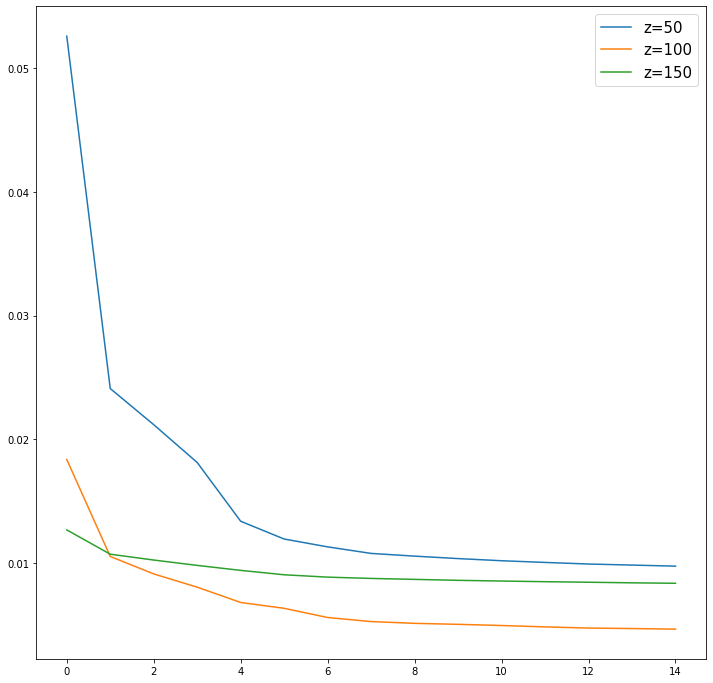

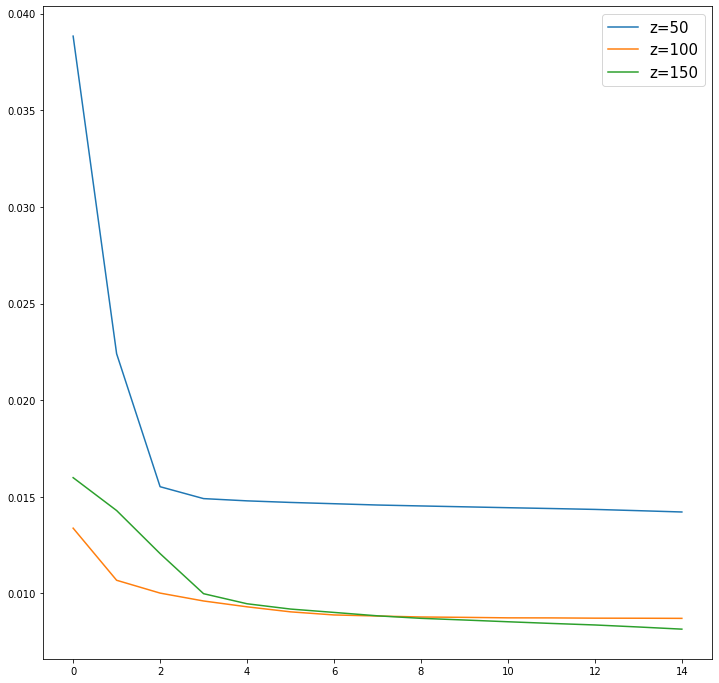

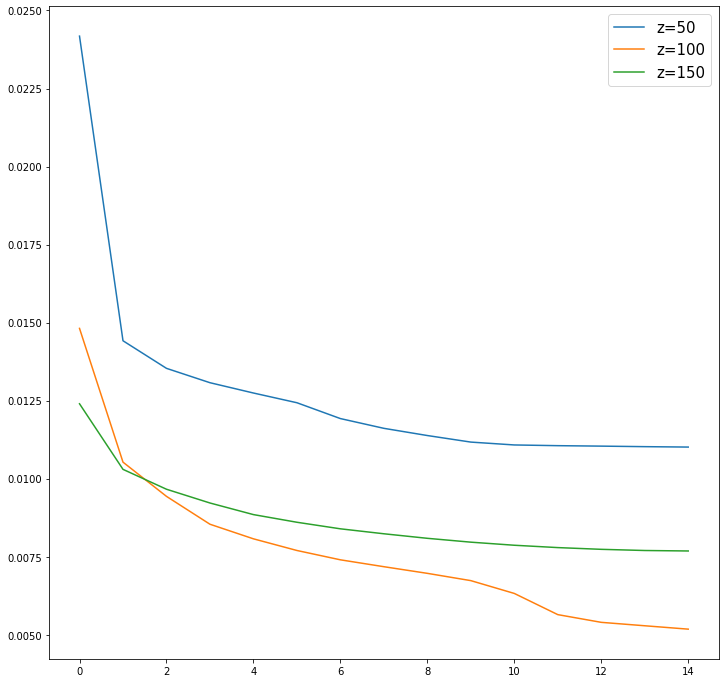

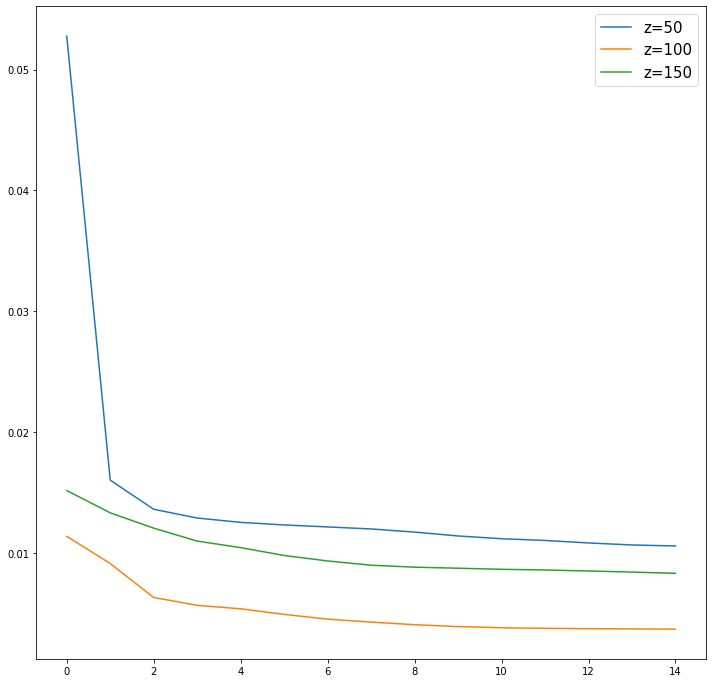

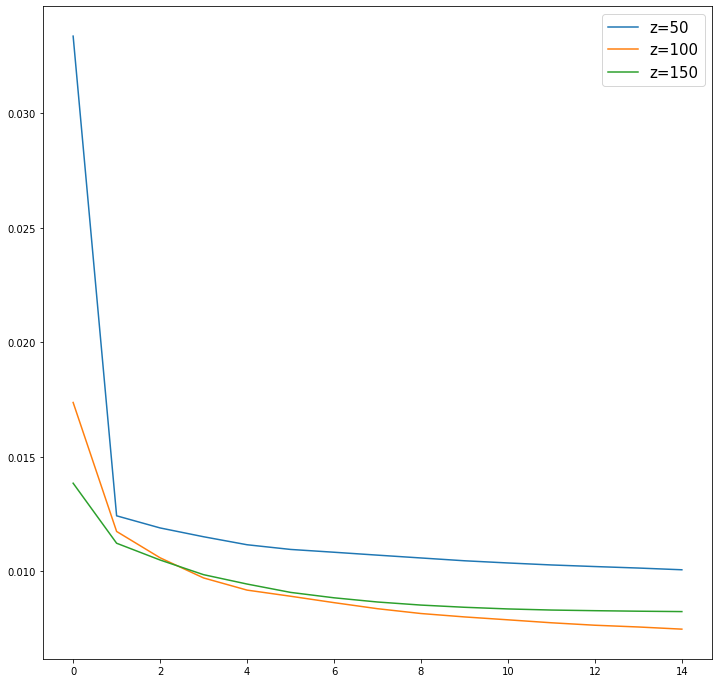

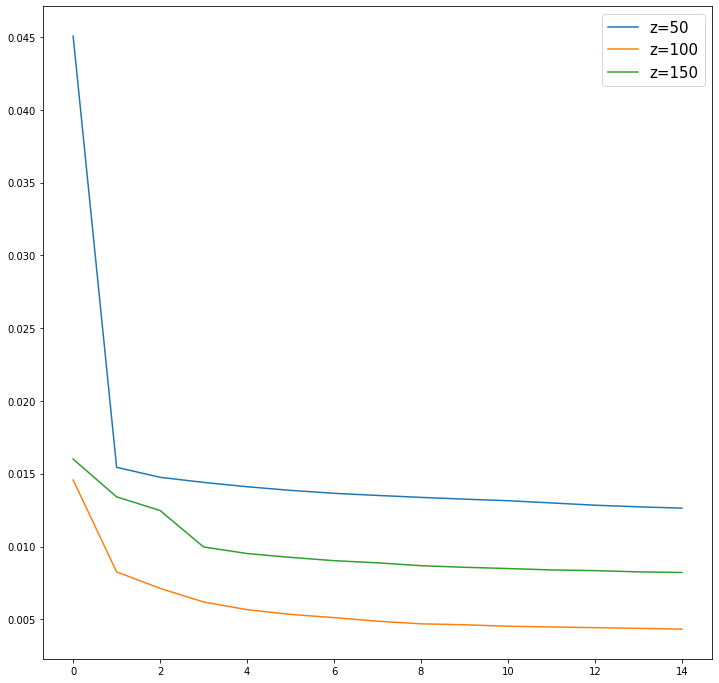

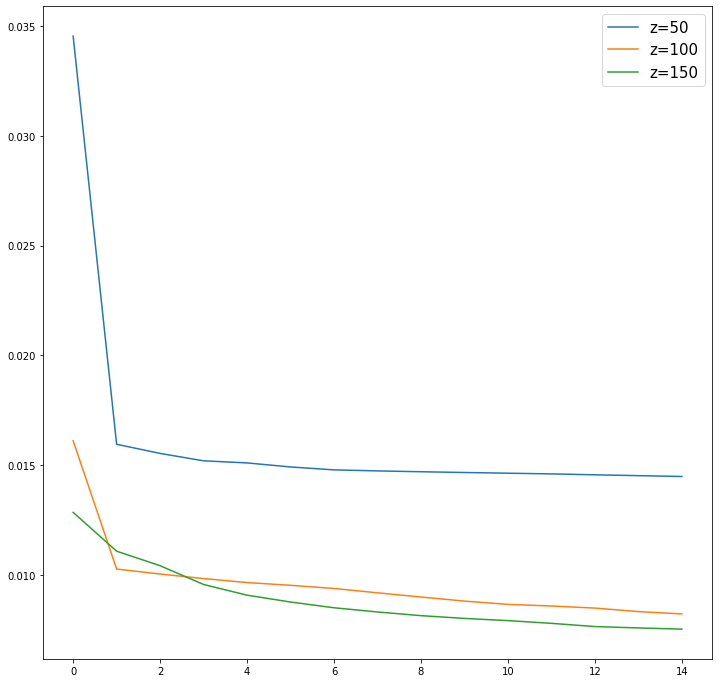

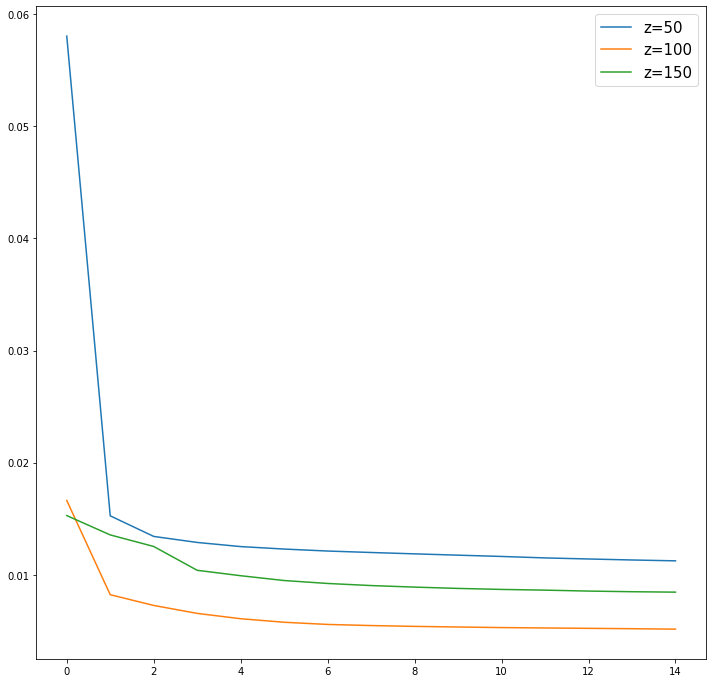

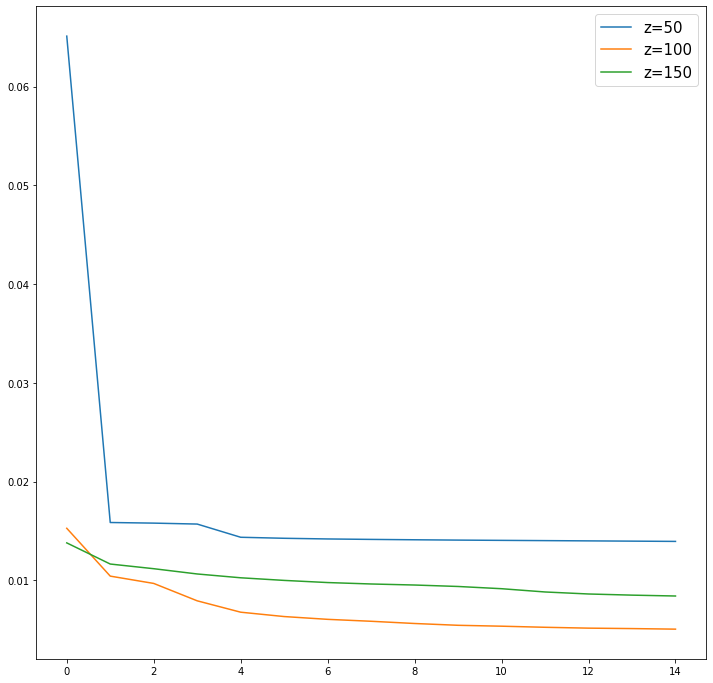

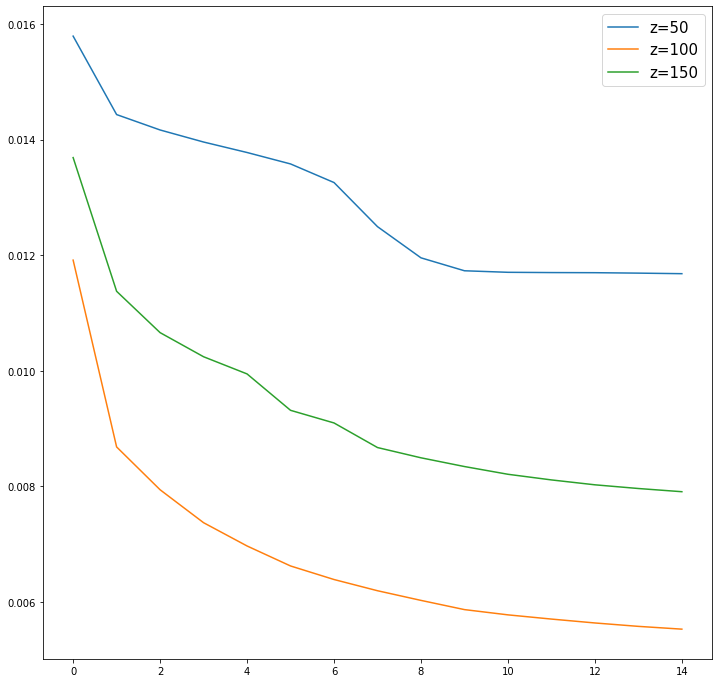

In [12]:
### Loop thru lots of random starting points
op = torch.optim.Adam
lr = 1e-2

# Accumulators
big_loss_list = []
big_x_list = []
for i in range(10):
    # Initialize x, the initial latent vector
    x_keep50 = Variable(Tensor(np.random.normal(0, 1, (1, 50))),requires_grad=False)
    x_keep100 = Variable(Tensor(np.random.normal(0, 1, (1, 100))),requires_grad=False)
    x_keep150 = Variable(Tensor(np.random.normal(0, 1, (1, 150))),requires_grad=False)
    
    generator_list = [generator50,generator100,generator150]
    x_keep_list = [x_keep50.unsqueeze(2).unsqueeze(2),
                   x_keep100.unsqueeze(2).unsqueeze(2),
                   x_keep150.unsqueeze(2).unsqueeze(2)]
    im_list = [im,im,im]
    
    loss_dict,im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=1500)
    big_loss_list.append(loss_dict)
    big_x_list.append(x_dict)

Min loss 50: 0.0097
Min loss 100: 0.0037
Min loss 150: 0.0075


Text(0.5, 1.0, 'Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization')

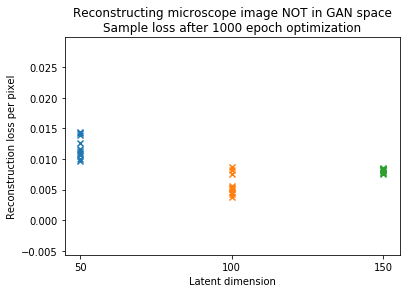

In [13]:
# Dot plots for all three latent dimensions
loss50 = []
loss100 = []
loss150 = []
for i,loss in enumerate(big_loss_list):
    loss50.append(np.min(loss['z=50']))
    loss100.append(np.min(loss['z=100']))
    loss150.append(np.min(loss['z=150']))
    
print("Min loss 50: {:2.4f}".format(np.min(loss50)))
print("Min loss 100: {:2.4f}".format(np.min(loss100)))
print("Min loss 150: {:2.4f}".format(np.min(loss150)))

plt.scatter(50*np.ones(len(loss50)),loss50,marker='x')
plt.scatter(100*np.ones(len(loss100)),loss100,marker='x')
plt.scatter(150*np.ones(len(loss150)),loss150,marker='x')
plt.xlabel("Latent dimension")
plt.xticks([50,100,150],[50,100,150])
plt.ylabel("Reconstruction loss per pixel")
plt.title("Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization")

In [14]:
# Find the best of the samples, optimizer further
# z = 50
idx = np.argmin(loss50)
x_keep = big_x_list[idx]['z=50']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,40000], gamma=0.6)
loss_list50, im_g50, x_out50 = grad_loop(im,x_keep,generator50,optimizer,
                                   scheduler=scheduler, n_epochs=25000,epsilon=1e-5)

# z = 100
idx = np.argmin(loss100)
x_keep = big_x_list[idx]['z=100']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,40000], gamma=0.6)
loss_list100, im_g100, x_out100 = grad_loop(im,x_keep,generator100,optimizer,
                                   scheduler=scheduler, n_epochs=25000,epsilon=1e-5)

# z = 150
idx = np.argmin(loss150)
x_keep = big_x_list[idx]['z=150']
# x = x_keep.clone().requires_grad_()
optimizer = torch.optim.Adam([x_keep],lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10000,20000,40000], gamma=0.6)
loss_list150, im_g150, x_out150 = grad_loop(im,x_keep,generator150,optimizer,
                                   scheduler=scheduler, n_epochs=25000,epsilon=1e-5)

Epoch 0	 Loss: 0.0096	 X Norm: 8.4764
Epoch 100	 Loss: 0.0096	 X Norm: 8.4788
Epoch 200	 Loss: 0.0096	 X Norm: 8.4817
Epoch 300	 Loss: 0.0095	 X Norm: 8.4761
Epoch 400	 Loss: 0.0095	 X Norm: 8.4614
Epoch 500	 Loss: 0.0094	 X Norm: 8.4335
Epoch 600	 Loss: 0.0094	 X Norm: 8.4065
Epoch 700	 Loss: 0.0094	 X Norm: 8.3950
Epoch 800	 Loss: 0.0094	 X Norm: 8.3862
Epoch 900	 Loss: 0.0094	 X Norm: 8.3841
Epoch 1000	 Loss: 0.0094	 X Norm: 8.3878
Epoch 1100	 Loss: 0.0094	 X Norm: 8.3926
Epoch 1200	 Loss: 0.0094	 X Norm: 8.3977
Epoch 1300	 Loss: 0.0094	 X Norm: 8.4079
Epoch 1400	 Loss: 0.0094	 X Norm: 8.4211
Epoch 1500	 Loss: 0.0094	 X Norm: 8.4396
Epoch 1600	 Loss: 0.0094	 X Norm: 8.4589
Epoch 1700	 Loss: 0.0094	 X Norm: 8.4819
Epoch 1800	 Loss: 0.0094	 X Norm: 8.4928
Epoch 1900	 Loss: 0.0093	 X Norm: 8.4986
Epoch 2000	 Loss: 0.0094	 X Norm: 8.5034
Epoch 2100	 Loss: 0.0093	 X Norm: 8.5109
Epoch 2200	 Loss: 0.0093	 X Norm: 8.5179
Epoch 2300	 Loss: 0.0093	 X Norm: 8.5186
Epoch 2400	 Loss: 0.0093	 X 

Epoch 19800	 Loss: 0.0093	 X Norm: 8.6844
Epoch 19900	 Loss: 0.0093	 X Norm: 8.6851
Epoch 20000	 Loss: 0.0093	 X Norm: 8.6859
Epoch 20100	 Loss: 0.0093	 X Norm: 8.6862
Epoch 20200	 Loss: 0.0093	 X Norm: 8.6864
Epoch 20300	 Loss: 0.0093	 X Norm: 8.6867
Epoch 20400	 Loss: 0.0093	 X Norm: 8.6870
Epoch 20500	 Loss: 0.0093	 X Norm: 8.6871
Epoch 20600	 Loss: 0.0093	 X Norm: 8.6873
Epoch 20700	 Loss: 0.0093	 X Norm: 8.6872
Epoch 20800	 Loss: 0.0093	 X Norm: 8.6877
Epoch 20900	 Loss: 0.0093	 X Norm: 8.6881
Epoch 21000	 Loss: 0.0093	 X Norm: 8.6884
Epoch 21100	 Loss: 0.0093	 X Norm: 8.6886
Epoch 21200	 Loss: 0.0093	 X Norm: 8.6887
Epoch 21300	 Loss: 0.0093	 X Norm: 8.6895
Epoch 21400	 Loss: 0.0093	 X Norm: 8.6895
Epoch 21500	 Loss: 0.0093	 X Norm: 8.6897
Epoch 21600	 Loss: 0.0093	 X Norm: 8.6901
Epoch 21700	 Loss: 0.0093	 X Norm: 8.6904
Epoch 21800	 Loss: 0.0093	 X Norm: 8.6906
Epoch 21900	 Loss: 0.0093	 X Norm: 8.6908
Epoch 22000	 Loss: 0.0093	 X Norm: 8.6907
Epoch 22100	 Loss: 0.0093	 X Norm:

Epoch 14300	 Loss: 0.0033	 X Norm: 10.7104
Epoch 14400	 Loss: 0.0033	 X Norm: 10.7102
Epoch 14500	 Loss: 0.0033	 X Norm: 10.7107
Epoch 14600	 Loss: 0.0033	 X Norm: 10.7123
Epoch 14700	 Loss: 0.0033	 X Norm: 10.7138
Epoch 14800	 Loss: 0.0033	 X Norm: 10.7148
Epoch 14900	 Loss: 0.0033	 X Norm: 10.7163
Epoch 15000	 Loss: 0.0033	 X Norm: 10.7175
Epoch 15100	 Loss: 0.0033	 X Norm: 10.7189
Epoch 15200	 Loss: 0.0033	 X Norm: 10.7199
Epoch 15300	 Loss: 0.0033	 X Norm: 10.7210
Epoch 15400	 Loss: 0.0033	 X Norm: 10.7224
Epoch 15500	 Loss: 0.0033	 X Norm: 10.7229
Epoch 15600	 Loss: 0.0033	 X Norm: 10.7241
Epoch 15700	 Loss: 0.0033	 X Norm: 10.7251
Epoch 15800	 Loss: 0.0033	 X Norm: 10.7266
Epoch 15900	 Loss: 0.0033	 X Norm: 10.7276
Epoch 16000	 Loss: 0.0033	 X Norm: 10.7283
Epoch 16100	 Loss: 0.0033	 X Norm: 10.7293
Epoch 16200	 Loss: 0.0033	 X Norm: 10.7305
Epoch 16300	 Loss: 0.0033	 X Norm: 10.7310
Epoch 16400	 Loss: 0.0033	 X Norm: 10.7325
Epoch 16500	 Loss: 0.0033	 X Norm: 10.7330
Epoch 16600

Epoch 8600	 Loss: 0.0071	 X Norm: 14.1310
Epoch 8700	 Loss: 0.0071	 X Norm: 14.1313
Epoch 8800	 Loss: 0.0071	 X Norm: 14.1353
Epoch 8900	 Loss: 0.0071	 X Norm: 14.1392
Epoch 9000	 Loss: 0.0071	 X Norm: 14.1415
Epoch 9100	 Loss: 0.0071	 X Norm: 14.1446
Epoch 9200	 Loss: 0.0071	 X Norm: 14.1456
Epoch 9300	 Loss: 0.0071	 X Norm: 14.1474
Epoch 9400	 Loss: 0.0071	 X Norm: 14.1493
Epoch 9500	 Loss: 0.0071	 X Norm: 14.1525
Epoch 9600	 Loss: 0.0071	 X Norm: 14.1556
Epoch 9700	 Loss: 0.0071	 X Norm: 14.1602
Epoch 9800	 Loss: 0.0071	 X Norm: 14.1671
Epoch 9900	 Loss: 0.0071	 X Norm: 14.1727
Epoch 10000	 Loss: 0.0071	 X Norm: 14.1758
Epoch 10100	 Loss: 0.0071	 X Norm: 14.1773
Epoch 10200	 Loss: 0.0071	 X Norm: 14.1780
Epoch 10300	 Loss: 0.0071	 X Norm: 14.1770
Epoch 10400	 Loss: 0.0071	 X Norm: 14.1747
Epoch 10500	 Loss: 0.0071	 X Norm: 14.1715
Epoch 10600	 Loss: 0.0071	 X Norm: 14.1674
Epoch 10700	 Loss: 0.0071	 X Norm: 14.1593
Epoch 10800	 Loss: 0.0071	 X Norm: 14.1532
Epoch 10900	 Loss: 0.0071

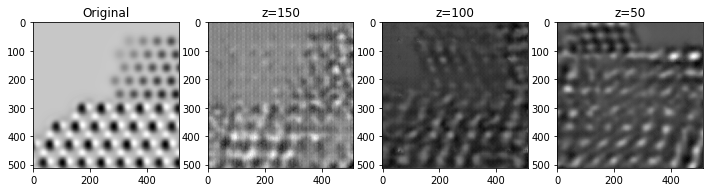

In [15]:
# Reconstruction
plt.figure(figsize=[12,6])
plt.subplot(1,4,1)
plt.title("Original")
plot_img(im,grayscale)

plt.subplot(1,4,2)
plt.title("z=150")
# after optimizing
with torch.no_grad():
    plot_img(im_g150,grayscale)

plt.subplot(1,4,3)
plt.title("z=100")
# after optimizing
with torch.no_grad():
    plot_img(im_g100,grayscale)

plt.subplot(1,4,4)
plt.title("z=50")
# after optimizing
with torch.no_grad():
    plot_img(im_g50,grayscale)

In [16]:
print("150: ",F.mse_loss(im_g150,im,reduction = 'sum'))
print("100: ",F.mse_loss(im_g100,im,reduction = 'sum'))
print("50: ",F.mse_loss(im_g50,im,reduction = 'sum'))
# print("50: {:2.4f}".format(np.min(loss50)))
# print("100: {:2.4f}".format(np.min(loss100)))
# print("150: {:2.4f}".format(np.min(loss150)))

150:  tensor(1827.1044, device='cuda:0', grad_fn=<MseLossBackward>)
100:  tensor(867.0854, device='cuda:0', grad_fn=<MseLossBackward>)
50:  tensor(2441.9951, device='cuda:0', grad_fn=<MseLossBackward>)


In [19]:
print("50: \tMean: {:2.6f}\tSD: {:2.6f}".format(x_out50.mean(),x_out50.std()))
print("100: \tMean: {:2.6f}\tSD: {:2.6f}".format(x_out100.mean(),x_out100.std()))
print("150: \tMean: {:2.6f}\tSD: {:2.6f}".format(x_out150.mean(),x_out150.std()))

50: 	Mean: -0.132381	SD: 1.235679
100: 	Mean: 0.103689	SD: 1.078223
150: 	Mean: 0.192937	SD: 1.152708


In [ ]:
op = torch.optim.Adam
lr = 1e-2
# Run the function
im_g, x_out, loss_list, big_x_list, big_loss_list, idx = sample_and_optimize(im,generator100,z=100,op=op,
                                                                lr=lr,num_samples=100,
                                                                num_early_epochs=1000,
                                                                num_total_epochs=30000)

In [ ]:
# Plot of min losses of the 100 samples
min_losses = []
for i,loss in enumerate(big_loss_list):
        min_losses.append(np.min(loss['z=100']))

# Same thing as a histogram
plt.hist(min_losses,bins=100)
plt.xlabel("Reconstruction Loss")
plt.ylabel("Count of samples")
plt.title("Reconstructing microscope image NOT in GAN space\nSample loss after 1000 epoch optimization")

In [ ]:
# Learning curve for all the samples
def plot_loss_curve_list(loss_list,title,dict_key='z=50',start_idx=0):    
    # Given a loss_dict where the optimizer name and LR are the key, plots the learning curves
    start_idx = round(start_idx,-2)
    plt.figure(figsize=[15,9])
    for k in range(len(loss_list)):
        plt.plot(np.arange(start_idx,100*len(loss_list[k][dict_key]),100),loss_list[k][dict_key][int(start_idx/100):])
    plt.ylabel("MSE Loss per pixel",fontsize=12)
    plt.xlabel("Epoch",fontsize=12)
    plt.title(title,fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
title = "Learning curve for {} random samples optimized for {} epochs\nLatent dimension {}" \
                     .format(100,1000,50)
plot_loss_curve_list(big_loss_list,title,start_idx=0)

In [ ]:
# Learning curve for best sample
plt.plot(np.arange(0,100*len(loss_list),100),loss_list)
plt.xlabel("Epoch after initial 1000")
plt.ylabel("Reconstruction Loss")
plt.title("Learning curve of best random sample for 50,000 more epochs")

In [ ]:
op = torch.optim.Adam
lr = 1e-2
generator_list = [generator50,generator100,generator150]
x_keep_list = [x_keep50.unsqueeze(2).unsqueeze(2),
               x_keep100.unsqueeze(2).unsqueeze(2),
               x_keep150.unsqueeze(2).unsqueeze(2)]
im_list = [im,im,im]

loss_dict,im_dict, x_dict = latent_dim_loop(generator_list,x_keep_list,im_list,op,lr,False,n_epochs=30000)
# convergence_loop(op_list,lr_list,generator,x.unsqueeze(2).unsqueeze(2),im)

In [ ]:
plot_loss_curve(loss_dict,title='Learning curves for different latent size\nDCGAN on image NOT in training set',start_idx=0)

In [ ]:
plt.figure(figsize=[12,4])
plt.subplot(1,4,1)
plt.title("Original")
plot_img(im,grayscale)

plt.subplot(1,4,2)
k = sorted(im_dict.keys())[2]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

plt.subplot(1,4,3)
k = sorted(im_dict.keys())[0]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

plt.subplot(1,4,4)
k = sorted(im_dict.keys())[1]
plt.title(k)
# after optimizing
with torch.no_grad():
    plot_img(im_dict[k],grayscale)

In [ ]:
# Compare loss across optimzers at a given epoch
for k in loss_dict.keys():
    print(k,": ",loss_dict[k][-1])